In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
def load_df():
  url = "https://raw.githubusercontent.com/ankit20027/collaborative-filtering-model/main/rating_final.csv"
  df = pd.read_csv(url)
  return df
df = load_df()
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [ ]:
user_num = len(pd.unique(df.userID))
item_num = len(pd.unique(df.placeID))
data = np.empty((3,user_num,item_num))
data[::] = np.nan
data.shape

(3, 138, 130)

In [ ]:
user_map = dict((e,i) for (i,e) in enumerate(pd.unique(df.userID)))
item_map = dict((e,i) for (i,e) in enumerate(pd.unique(df.placeID)))

for i in range(len(df)):
  for j in range(3):
    data[j][user_map[df.iloc[i,0]]][item_map[df.iloc[i,1]]] = df.iloc[i,j+2]

In [ ]:
def make_df_from_np(data, user_num, col_num):
  user_ls = []
  item_ls = []
  final_rat = []
  food_rat = []
  service_rat = []
  for i in range(user_num):
    for j in range(int(item_num)):
      if (not np.isnan(data[0][i][j])):
        user_ls.append(i)
        item_ls.append(j)
        final_rat.append(data[0][i][j])
        food_rat.append(data[1][i][j])
        service_rat.append(data[2][i][j])
  dtf = pd.DataFrame({
      'user_id': user_ls,
      'item_id': item_ls,
      'final_rating': final_rat,
      'food_rating': food_rat,
      'service_rating': service_rat
  })
  return dtf

In [ ]:
dtf = make_df_from_np(data, user_num, item_num)
dtf

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dtf, dtf.iloc[:,2:], test_size=0.2, random_state=42)

In [ ]:
X_test

Change

In [ ]:
# embeddings
embeddings_size = 26
usr, prd = user_num, item_num
# Users (1,embedding_size)
xusers_in = keras.layers.Input(name="xusers_in", shape=(1,))
# xuser_dense = keras.layers.Dense(name="xuser_dense", units=1, activation='relu')(xusers_in)
xusers_emb = keras.layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = keras.layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)
# Products (1,embedding_size)
xproducts_in = keras.layers.Input(name="xproducts_in", shape=(1,))
# xproduct_dense = keras.layers.Dense(name="xproduct_dense", units=3, activation='relu')(xproducts_in)
xproducts_emb = keras.layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = keras.layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)
# Product (1)
xx = keras.layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])
# Predict ratings (1)
y_out = keras.layers.Dense(name="y_out", units=1, activation='relu')(xx)
# Compile
model1 = keras.models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])
model2 = keras.models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])
model1.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 26)        3588        ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 26)        3380        ['xproducts_in[0][0]']           
                                                                             

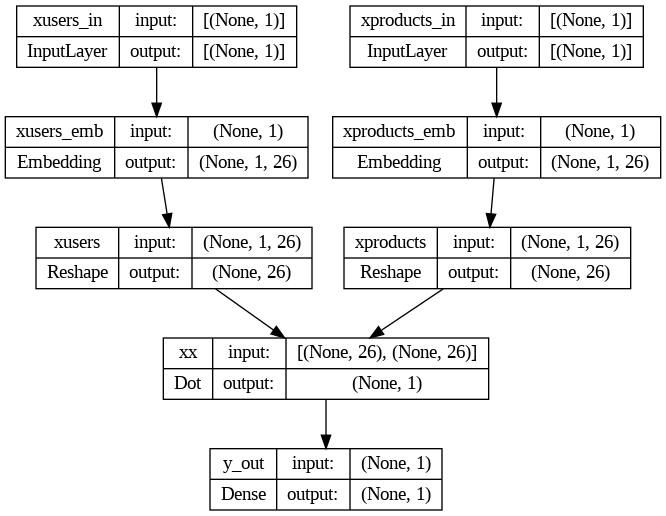

In [ ]:
keras.utils.plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
def conv_to_val(dtfr, col_name, l_mid, u_mid):
  dtfr.loc[dtfr[col_name]>=u_mid, col_name] = 2
  dtfr.loc[dtfr[col_name]<u_mid, col_name] = 1
  dtfr.loc[dtfr[col_name]<l_mid, col_name] = 0
  return dtfr

#DNN1

In [ ]:

model1 = keras.models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])
model2 = keras.models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])
epo = 8
bth = 8
training1 = model1.fit(x=[X_train["user_id"], X_train["item_id"]], y=y_train["food_rating"], epochs=epo, batch_size=bth, verbose=0, validation_split=0.3)
model1 = training1.model

dnnData = X_test #y_test to match
# Test on sareplace dataframe valume
dnnData[f"out_food"] = model1.predict([X_test["user_id"], X_test["item_id"]])

training2 = model2.fit(x=[X_train["user_id"], X_train["item_id"]], y=y_train["service_rating"], epochs=epo, batch_size=bth, verbose=0, validation_split=0.3)
model2 = training2.model
# Test on same
dnnData[f"out_service"] = model2.predict([X_test["user_id"], X_test["item_id"]])
dnnData

8/8 [==============================] - 0s 2ms/step


,user_id,item_id,final_rating,food_rating,service_rating,out_food,out_service
538,68,29,1.0,0.0,1.0,1.212557,1.152564
673,83,107,1.0,1.0,1.0,1.034383,0.735434
578,72,78,2.0,2.0,1.0,0.686245,0.351516
242,39,71,1.0,2.0,1.0,0.429014,0.403074
1063,123,112,0.0,0.0,0.0,0.227363,0.210067
...,...,...,...,...,...,...,...
3,0,3,1.0,2.0,2.0,1.247675,1.570803
737,91,127,0.0,0.0,0.0,0.476444,0.508138
717,90,85,2.0,1.0,0.0,0.752730,0.513246
842,103,37,2.0,0.0,2.0,1.123843,1.498494


In [ ]:
dtf = make_df_from_np(data, user_num, item_num)

In [ ]:
dtf

,user_id,item_id,final_rating,food_rating,service_rating
0,0,0,2.0,2.0,2.0
1,0,1,2.0,2.0,1.0
2,0,2,2.0,2.0,2.0
3,0,3,1.0,2.0,2.0
4,0,83,0.0,1.0,1.0
...,...,...,...,...,...
1156,136,17,1.0,1.0,1.0
1157,136,18,1.0,2.0,1.0
1158,137,21,1.0,1.0,0.0
1159,137,22,2.0,2.0,1.0


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(dtf.iloc[:,3:], dtf.iloc[:,2], test_size=0.2, random_state=42)
X_train = dtf.iloc[:,3:]
y_train = dtf.iloc[:,2]
X_test = dnnData.iloc[:,5:]

In [ ]:
X_test

,out_food,out_service
538,1.212557,1.152564
673,1.034383,0.735434
578,0.686245,0.351516
242,0.429014,0.403074
1063,0.227363,0.210067
...,...,...
3,1.247675,1.570803
737,0.476444,0.508138
717,0.752730,0.513246
842,1.123843,1.498494


# DNN 2

In [ ]:
from pandas.core.common import random_state
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(2,), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.08),
    keras.layers.Dense(1, activation='relu'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])
model.fit(X_train, y_train, verbose=0, epochs=100, batch_size=128)

In [ ]:
pred = model.predict(X_test)
final_rating = []
for i in pred:
  if (i<0.75):
    final_rating.append(0)
  elif (i<1.15):
    final_rating.append(1)
  else:
    final_rating.append(2)
# my_df = pd.DataFrame(y_test.tolist(),columns=['real'])
# my_df['pred'] = pred
dnnData['final_pred'] = final_rating
dnnData['final_pred_val'] = pred
dnnData

8/8 [==============================] - 0s 2ms/step


,user_id,item_id,final_rating,food_rating,service_rating,out_food,out_service,final_pred,final_pred_val
538,68,29,1.0,0.0,1.0,1.212557,1.152564,1,1.142299
673,83,107,1.0,1.0,1.0,1.034383,0.735434,1,0.922996
578,72,78,2.0,2.0,1.0,0.686245,0.351516,0,0.663882
242,39,71,1.0,2.0,1.0,0.429014,0.403074,0,0.540866
1063,123,112,0.0,0.0,0.0,0.227363,0.210067,0,0.256650
...,...,...,...,...,...,...,...,...,...
3,0,3,1.0,2.0,2.0,1.247675,1.570803,2,1.296530
737,91,127,0.0,0.0,0.0,0.476444,0.508138,0,0.592982
717,90,85,2.0,1.0,0.0,0.752730,0.513246,0,0.720698
842,103,37,2.0,0.0,2.0,1.123843,1.498494,2,1.222644


In [ ]:
def find_stats(pred, real):
  sum = 0
  for i in range(len(pred)):
    sum += abs(pred[i]-real[i])
  print(" MAE: ",sum/len(pred))
  print(" NMAE: ",sum/(len(pred)*3))
  print()

print("Overall Stats:")
find_stats(dnnData['final_pred'].tolist(), dnnData['final_rating'].tolist())

print("\nMulti Criteria Stats:")
print(" For food:")
find_stats(dnnData['out_food'].tolist(), dnnData['food_rating'].tolist())
print(" For service:")
find_stats(dnnData['out_service'].tolist(), dnnData['service_rating'].tolist())

print("Data Sparsity:")
print(f" {(1-(len(df)/(user_num*item_num)))*100}")

Overall Stats:
 MAE:  0.6909871244635193
 NMAE:  0.23032904148783978


Multi Criteria Stats:
 For food:
 MAE:  0.7353960113208181
 NMAE:  0.24513200377360606

 For service:
 MAE:  0.64224313730334
 NMAE:  0.21408104576778003

Data Sparsity:
 93.52842809364549
